In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math

Odom at setp 10 is: 
 [ 0.3449921   0.00058428 -0.02110238]
Observation at setp 10 of  : 
 [[ 4.99484536  2.20044646  1.60770444  3.54046849]
 [-0.51960925  2.94118772 -1.46267738  0.46274556]
 [ 2.          4.         11.         14.        ]]
(30, 2)
[9.84650853 3.26720195]
(np.float64(0.0), np.float64(1.0), np.float64(0.0))
(np.float64(0.7853981633974483), np.float64(1.4142135623730951), np.float64(-0.7853981633974483))


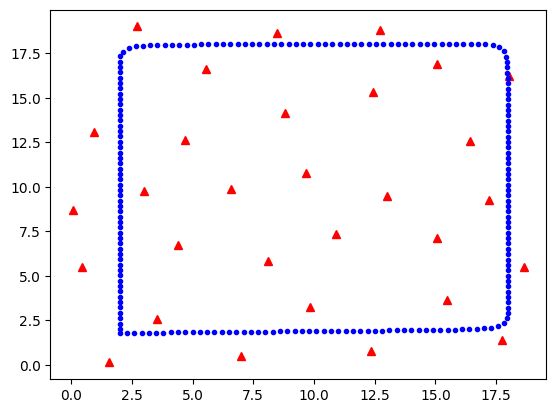

In [16]:
# Load the dataset from a pickle file located at the specified path
data = pickle.load(open('/home/dopamine/Downloads/dataset_2d_landmarks.p', 'rb'))

# Extract the 'M' array from the dataset, likely representing landmark positions
M = data['M']

# Extract the ground truth trajectory from the dataset
gt_traj = data['gt']

# Create a new figure window for plotting (figure number 1)
plt.figure(1)

# Plot the x and y coordinates of landmarks (M[:,0] and M[:,1]) as red triangles
plt.plot(M[:,0], M[:,1], '^r')

# Loop through ground truth trajectory indices from 0 to length of gt_traj, stepping by 10
for i in range(0, len(gt_traj), 10):
    # Plot the x and y coordinates of the ground truth trajectory at index i as blue dots
    plt.plot(gt_traj[i][0], gt_traj[i][1], '.b')

# Extract odometry data at time step 10 from the dataset
odom_10 = data['odom'][10]

# Print the odometry data at step 10 with a descriptive message
print('Odom at setp 10 is: \n', odom_10)

# Extract observation data at time step 12 from the dataset
z_10 = data['z'][12]

# Print the observation data at step 12 (labeled as step 10, possibly a typo) with a descriptive message
print('Observation at setp 10 of  : \n', z_10)

# Print the shape of the M array (number of rows and columns)
print(M.shape)

# Print the second row (index 1) of the M array
print(M[1])

# Define a function to wrap an angle theta to the range [-π, π]
def wrapiToPi(theta):
    # Subtract 2π from theta until it is less than or equal to π
    while theta > np.pi:
        theta -= 2*np.pi
    # Add 2π to theta until it is greater than or equal to -π
    while theta < -np.pi:
        theta += 2*np.pi
    # Return the wrapped angle
    return theta

# Define a function to compute the inverse motion model given two poses u_t0 and u_t1
def inverse_motion_model(u):
    # Unpack the initial pose (x, y, theta) and final pose (x', y', theta')
    u_t0, u_t1 = u

    # Extract x, y, theta from the initial pose
    x = u_t0[0]
    y = u_t0[1]
    theta = u_t0[2]

    # Extract x', y', theta' from the final pose
    x_dash = u_t1[0]
    y_dash = u_t1[1]
    theta_dash = u_t1[2]

    # Calculate translation distance between the two poses using Euclidean distance
    trans = np.sqrt((x_dash - x)**2 + (y_dash - y)**2)

    # Calculate the first rotation (angle to the new position relative to initial orientation)
    rot_1 = wrapiToPi(np.arctan2(y_dash - y, x_dash - x) - theta)

    # Calculate the second rotation (change in orientation after moving to the new position)
    rot_2 = wrapiToPi(theta_dash - (theta + rot_1))

    # Return the first rotation, translation, and second rotation
    return rot_1, trans, rot_2

# Test the inverse motion model with initial pose [0,0,0] and final pose [1,0,0]
test_1 = inverse_motion_model([[0,0,0], [1,0,0]])

# Test the inverse motion model with initial pose [0,0,0] and final pose [1,1,0]
test_2 = inverse_motion_model([[0,0,0], [1,1,0]])

# Print the result of the first test case (rot_1, trans, rot_2)
print(test_1)

# Print the result of the second test case (rot_1, trans, rot_2)
print(test_2)

In [17]:
def ekf_predict(x_pred, P_pred, u, Q=np.zeros((3, 3))):
    # Reshape the state vector to ensure it's a 3x1 column vector for consistent matrix operations
    x_pred = x_pred.reshape(3, 1)
    
    # Reshape the covariance matrix to ensure it's a 3x3 matrix for matrix multiplications
    P_pred = P_pred.reshape(3, 3)

    # Extract control inputs (rot1, trans, rot2) from the control vector u using the inverse motion model
    rot1, trans, rot2 = inverse_motion_model(u)
    
    # Extract the current heading angle (theta) from the state vector's third component
    theta = x_pred[2, 0]

    # Update the predicted state using the motion model:
    # - x position: add translation * cos(theta + rot1)
    # - y position: add translation * sin(theta + rot1)
    # - heading: add rot1 + rot2
    x_pred = x_pred + np.array([
        [trans * np.cos(theta + rot1)],
        [trans * np.sin(theta + rot1)],
        [rot1 + rot2]
    ])
    
    # Normalize the heading angle to the range [-pi, pi] to avoid numerical issues
    x_pred[2][0] = wrapiToPi(x_pred[2][0])

    # Compute the Jacobian of the motion model with respect to the state (A_x)
    # This linearizes the state transition for covariance propagation
    A_x = np.array([
        [1, 0, -trans * np.sin(theta + rot1)],  # Partial derivative of x with respect to x, y, theta
        [0, 1,  trans * np.cos(theta + rot1)],  # Partial derivative of y with respect to x, y, theta
        [0, 0, 1]                               # Partial derivative of theta with respect to x, y, theta
    ])

    # Compute the Jacobian of the motion model with respect to the control inputs (B_u)
    # This maps control noise to the state space
    B_u = np.array([
        [-trans * np.sin(theta + rot1), np.cos(theta + rot1), 0],  # Effect of rot1, trans, rot2 on x
        [ trans * np.cos(theta + rot1), np.sin(theta + rot1), 0],  # Effect of rot1, trans, rot2 on y
        [1, 0, 1]                                                  # Effect of rot1, trans, rot2 on theta
    ])

    # Update the covariance matrix using the EKF prediction formula:
    # P = A_x * P * A_x^T + B_u * Q * B_u^T, where Q is the control noise covariance
    P_pred = A_x @ P_pred @ A_x.T + B_u @ Q @ B_u.T

    # Return the predicted state vector and covariance matrix
    return x_pred, P_pred

In [18]:
def ekf_correct(x, P, z, M, R):
    # Defines the EKF correction function with inputs:
    # x: State vector (3x1) [x_position, y_position, theta (orientation)]
    # P: State covariance matrix (3x3)
    # z: Measurement matrix (3xm), where columns are [range, bearing, landmark_id]
    # M: Landmark map, where M[id] gives [mx, my] coordinates of landmark id
    # R: Measurement noise covariance matrix (2x2)

    for i in range(z.shape[1]):
        # Loop over each measurement in z (number of columns = number of measurements)

        theta = x[2][0]
        # Extract the current orientation (theta) from the state vector x at index 2

        id = int(z[2][i])
        # Get the landmark ID from the third row of the i-th measurement, cast to integer

        m = M[id]
        # Retrieve the landmark coordinates [mx, my] from the map M using the landmark ID

        mx, my = m[0], m[1]
        # Assign landmark x-coordinate (mx) and y-coordinate (my) from m

        est_x = x[0][0]
        # Extract the estimated x-position from the state vector x at index 0

        est_y = x[1][0]
        # Extract the estimated y-position from the state vector x at index 1

        dx = mx - est_x
        # Compute the difference in x-coordinates between landmark and estimated position

        dy = my - est_y
        # Compute the difference in y-coordinates between landmark and estimated position

        r = np.sqrt(dx**2 + dy**2)
        # Calculate the expected range (distance) from the robot to the landmark

        h_x = np.array([
            [r],
            [wrapiToPi(np.arctan2(dy, dx) - theta)]
        ])
        # Compute the expected measurement h(x):
        # - First element: range (r)
        # - Second element: bearing (angle from robot to landmark, relative to theta)
        # wrapiToPi ensures the bearing is in [-π, π]

        z_i = np.array(z[:2, i]).reshape(2, 1)
        # Extract the i-th measurement [range, bearing] from z and reshape to 2x1

        y = z_i - h_x
        # Compute the innovation (measurement residual): actual measurement minus expected

        y[1][0] = wrapiToPi(y[1][0])
        # Normalize the bearing component of the innovation to [-π, π]

        C_x = np.array([
            [-(dx)/r, -(dy)/r, 0],
            [dy/(r**2), -dx/(r**2), -1]
        ])
        # Compute the measurement Jacobian C_x (partial derivatives of h(x) w.r.t. state):
        # - First row: derivatives of range w.r.t. x, y, theta
        # - Second row: derivatives of bearing w.r.t. x, y, theta

        S = C_x @ P @ C_x.T + R
        # Compute the innovation covariance S:
        # S = C_x * P * C_x^T + R, where @ denotes matrix multiplication

        try:
            S_inv = np.linalg.inv(S)
            # Attempt to compute the inverse of the innovation covariance S
        except np.linalg.LinAlgError:
            # Handle case where S is singular (non-invertible)
            print(f"Warning: S is singular at observation {i}. Skipping this update.")
            # Print a warning message indicating the issue
            continue
            # Skip this measurement and proceed to the next iteration

        K = P @ C_x.T @ S_inv
        # Compute the Kalman Gain: K = P * C_x^T * S^(-1)

        x = x + K @ y
        # Update the state vector: x = x + K * y (incorporate measurement residual)

        x[2][0] = wrapiToPi(x[2][0])
        # Normalize the updated orientation (theta) to [-π, π]

        P = (np.eye(3) - K @ C_x) @ P
        # Update the state covariance: P = (I - K * C_x) * P, where I is 3x3 identity

    return x, P
    # Return the updated state vector x and covariance matrix P

In [19]:
# Define standard deviation for x-position uncertainty (0.25 units)
sigma_x = 0.25

# Define standard deviation for y-position uncertainty (0.25 units)
sigma_y = 0.25

# Convert angular standard deviation from 10 degrees to radians
sigma_theta = np.deg2rad(10)

# Create process noise covariance matrix Q (3x3 diagonal matrix) using squared standard deviations
Q = np.diag(np.array([sigma_x, sigma_y, sigma_theta])**2)

# Define standard deviation for range measurement uncertainty (0.1 units)
sigma_r = 0.1

# Convert angular standard deviation for bearing measurement from 5 degrees to radians
sigma_phi = np.deg2rad(5)

# Create measurement noise covariance matrix R (2x2 diagonal matrix) using squared standard deviations
R = np.diag(np.array([sigma_r, sigma_phi])**2)

# Initialize state vector x (3x1) with x=2, y=2, theta=pi/2 (90 degrees)
x = np.array([2, 2, np.pi / 2]).reshape(3, 1)

# Initialize state covariance matrix P (3x3) with position variances of 1 and orientation variance of pi/3
P = np.array([
    [1, 0, 0],  # Variance of x, no covariance
    [0, 1, 0],  # Variance of y, no covariance
    [0, 0, np.pi / 3]  # Variance of theta, no covariance
])

# Loop through time steps 1 to 9 for EKF prediction and correction
for i in range(1, 10):
    # Extract control inputs (odometry) for current and previous steps
    u = [data['odom'][i - 1], data['odom'][i]]

    # Get measurement vector z for current step
    z = data['z'][i]

    # Perform EKF prediction step to estimate new state and covariance
    x_pred, P_pred = ekf_predict(x, P, u, Q)

    # Perform EKF correction step using predicted state, measurement, and measurement model
    x, P = ekf_correct(x_pred, P_pred, z, M, R)

# Print final estimated state vector x after EKF iterations
print("Final EKF state x =\n", x)

# Print final state covariance matrix P after EKF iterations
print("Final EKF covariance P =\n", P)

# Print ground truth state at step 10 for comparison
print("Ground truth at step 10 =\n", data['gt'][10])

Final EKF state x =
 [[1.94772947]
 [2.26725661]
 [1.57772673]]
Final EKF covariance P =
 [[ 7.84560095e-04  3.15219150e-05 -1.03225734e-04]
 [ 3.15219150e-05  4.17195332e-03 -5.57710648e-04]
 [-1.03225734e-04 -5.57710648e-04  2.55443628e-03]]
Ground truth at step 10 =
 [2.         2.33       1.57079633]


In [20]:
# Define process noise covariance matrix
# sigma_x: Standard deviation for x-position noise (0.25 units)
# sigma_y: Standard deviation for y-position noise (0.25 units)
# sigma_theta: Standard deviation for orientation noise (10 degrees, converted to radians)
sigma_x = 0.25
sigma_y = 0.25
sigma_theta = np.deg2rad(10)

# Create process noise covariance matrix Q
# Q is a 3x3 diagonal matrix with variances (squared standard deviations) for x, y, and theta
Q = np.diag(np.array([sigma_x, sigma_y, sigma_theta])**2)

# Define measurement noise covariance matrix
# sigma_r: Standard deviation for range measurement noise (0.1 units)
# sigma_phi: Standard deviation for bearing measurement noise (5 degrees, converted to radians)
sigma_r = 0.1
sigma_phi = np.deg2rad(5)

# Create measurement noise covariance matrix R
# R is a 2x2 diagonal matrix with variances for range and bearing measurements
R = np.diag(np.array([sigma_r, sigma_phi])**2)

# Initialize the state belief
# x: Initial state vector [x_position, y_position, orientation] (column vector)
# Starting at position (2, 2) with orientation pi/2 (90 degrees, facing upward)
x = np.array([2, 2, np.pi / 2]).reshape(3, 1)

# Initialize the covariance matrix of the state belief
# P: 3x3 covariance matrix representing uncertainty in x, y, and theta
# Diagonal elements: variance of 1 for x and y, pi/3 for theta
P = np.array([
    [1, 0, 0],        # Variance in x-position, no correlation
    [0, 1, 0],        # Variance in y-position, no correlation
    [0, 0, np.pi / 3] # Variance in orientation
])

# Initialize list to store estimated trajectory
# est_traj: List to record [x, y] positions of the estimated trajectory
est_traj = [[x[0, 0], x[1, 0]]]

# Extended Kalman Filter (EKF) main loop
# Iterates through odometry data starting from index 1 to process motion and sensor updates
for i in range(1, len(data['odom'])):  # Assumes 'data' contains 'odom' (odometry inputs)
    # Extract control input (odometry) between consecutive time steps
    # u: Control input, difference between odometry at step i-1 and i
    u = [data['odom'][i - 1], data['odom'][i]]  # Assumes odometry data structure is defined

    # Extract sensor measurement at current time step
    # z: Measurement vector (e.g., [range, bearing]) at step i
    z = data['z'][i]  # Assumes 'data' contains 'z' (sensor measurements)

    # Prediction step of EKF
    # x_pred: Predicted state based on motion model and control input
    # P_pred: Predicted covariance incorporating process noise
    x_pred, P_pred = ekf_predict(x, P, u, Q)  # Assumes ekf_predict function is defined

    # Correction step of EKF
    # Updates state and covariance using sensor measurements
    # M: Measurement model or landmarks (assumed to be defined elsewhere)
    x, P = ekf_correct(x_pred, P_pred, z, M, R)  # Assumes ekf_correct function is defined

    # Append current estimated position [x, y] to trajectory
    est_traj.append([x[0, 0], x[1, 0]])

# Print final estimated pose
# Displays the final state vector [x, y, theta] after all EKF iterations
print("Final estimated pose:\n", x)

# Print ground truth pose at final step
# Assumes 'data' contains 'gt' (ground truth) with 2091 steps
# Note: Hardcoded index 2091 may need validation for correctness
print("Ground truth at final step:\n", data['gt'][2091])

Final estimated pose:
 [[ 2.01745659]
 [ 1.82559368]
 [-3.13180168]]
Ground truth at final step:
 [ 1.97535062  1.80216482 -3.1292476 ]


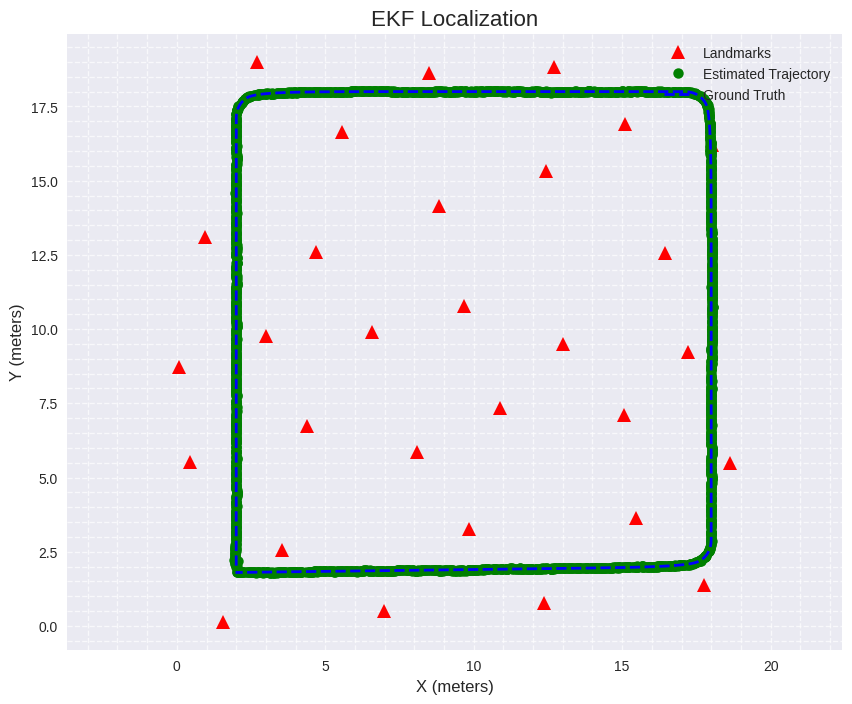

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Check if seaborn is installed and use appropriate style
try:
    import seaborn  # Check if seaborn is installed
    plt.style.use('seaborn-v0_8')  # Use updated seaborn style for Matplotlib 3.6+
except ImportError:
    print("Seaborn not installed. Falling back to 'ggplot' style.")
    plt.style.use('ggplot')  # Fallback to a built-in Matplotlib style

# Create a new figure with a specific size (width, height in inches)
plt.figure(figsize=(10, 8))

# Plot landmarks with larger markers
try:
    plt.plot(M[:, 0], M[:, 1], '^r', markersize=10, label='Landmarks')
except NameError:
    print("Error: 'M' is not defined. Please provide a valid 2D NumPy array.")
    raise

# Plot estimated trajectory with larger dots
try:
    plt.plot([p[0] for p in est_traj], [p[1] for p in est_traj], '.g', markersize=15, label='Estimated Trajectory')
except NameError:
    print("Error: 'est_traj' is not defined. Please provide a valid list of points.")
    raise

# Plot ground truth with thicker dashed line
try:
    plt.plot([p[0] for p in data['gt']], [p[1] for p in data['gt']], '--b', linewidth=2, label='Ground Truth')
except (NameError, KeyError):
    print("Error: 'data' or 'data['gt']' is not defined. Please provide a valid dictionary with 'gt' key.")
    raise

# Add legend with custom placement (upper right)
plt.legend(loc='upper right')

# Set title and labels with larger font for readability
plt.title('EKF Localization', fontsize=16)
plt.xlabel('X (meters)', fontsize=12)
plt.ylabel('Y (meters)', fontsize=12)

# Add grid with major and minor ticks
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.minorticks_on()

# Optional: Set axis limits based on data (uncomment and adjust if you have data bounds)
# x_min, x_max = min(np.min(M[:, 0]), min(p[0] for p in est_traj), min(p[0] for p in data['gt'])), max(np.max(M[:, 0]), max(p[0] for p in est_traj), max(p[0] for p in data['gt']))
# y_min, y_max = min(np.min(M[:, 1]), min(p[1] for p in est_traj), min(p[1] for p in data['gt'])), max(np.max(M[:, 1]), max(p[1] for p in est_traj), max(p[1] for p in data['gt']))
# plt.xlim(x_min - 0.1 * (x_max - x_min), x_max + 0.1 * (x_max - x_min))
# plt.ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))

# Ensure equal aspect ratio for accurate spatial representation
plt.axis('equal')

# Display the plot
plt.show()